<a href="https://colab.research.google.com/github/Chanthrothayan/Network-Traffic-Classification/blob/main/RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50
670/670 [==============================] - 6s 6ms/step - loss: 0.1402 - accuracy: 0.9764 - val_loss: 0.0106 - val_accuracy: 0.9998
Epoch 2/50
670/670 [==============================] - 4s 5ms/step - loss: 0.0053 - accuracy: 0.9998 - val_loss: 0.0039 - val_accuracy: 0.9993
Epoch 3/50
670/670 [==============================] - 2s 4ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 0.0025 - val_accuracy: 0.9993
Epoch 4/50
670/670 [==============================] - 2s 4ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.0018 - val_accuracy: 0.9998
Epoch 5/50
670/670 [==============================] - 2s 4ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0015 - val_accuracy: 0.9998
Epoch 6/50
670/670 [==============================] - 4s 6ms/step - loss: 8.0042e-04 - accuracy: 0.9998 - val_loss: 0.0012 - val_accuracy: 0.9998
Epoch 7/50
670/

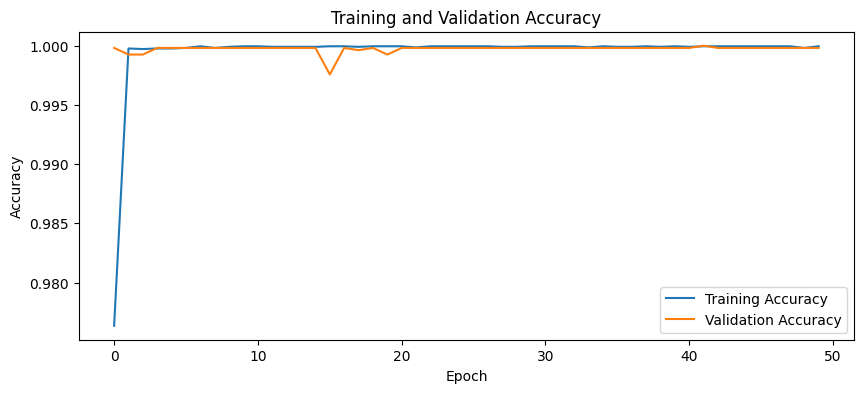

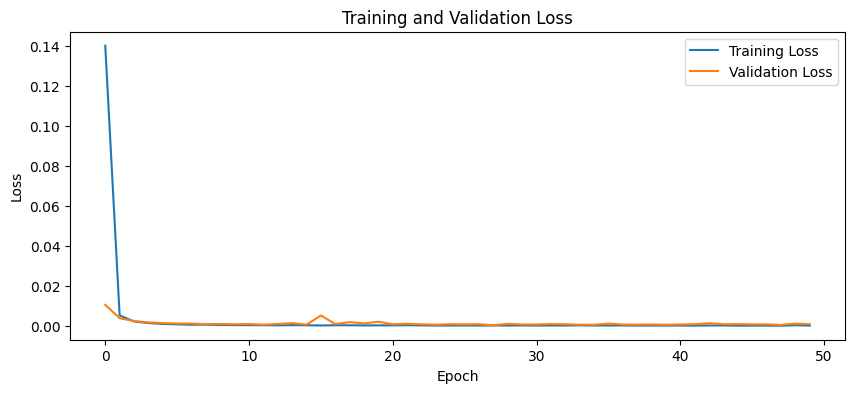

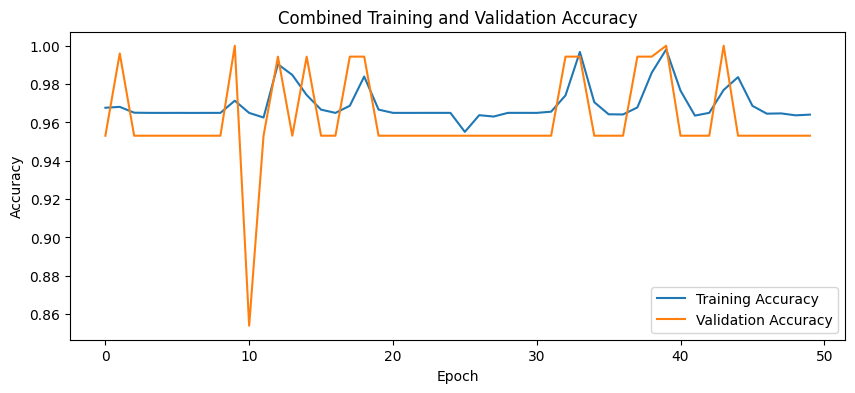

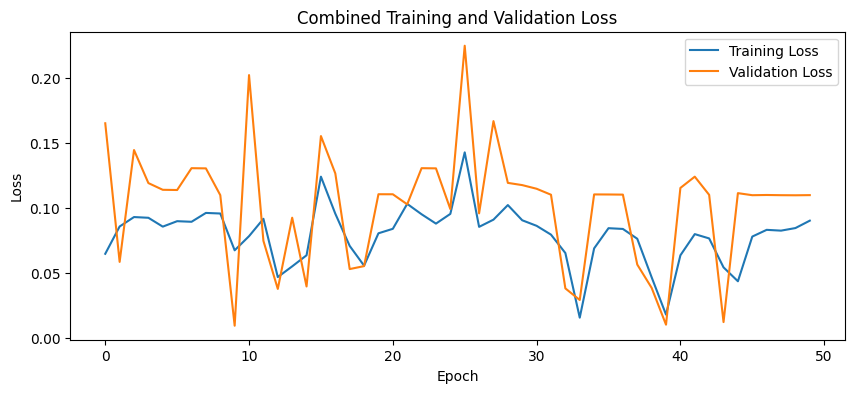

Unique classes in y_test: [0 1 2]
Unique classes in y_pred: [0 1 2]
Classification Report:
                 precision    recall  f1-score   support

Benign Traffic       1.00      1.00      1.00      1708
    ARP Poison       1.00      1.00      1.00       422
     ARP Flood       1.00      1.00      1.00      4570

      accuracy                           1.00      6700
     macro avg       1.00      1.00      1.00      6700
  weighted avg       1.00      1.00      1.00      6700



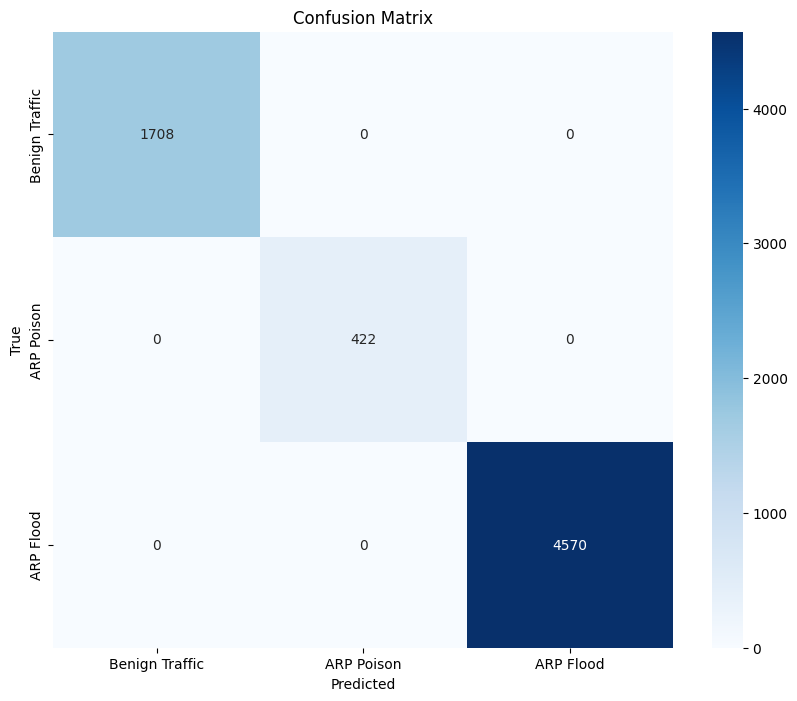

In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
drive.mount('/content/drive')

def mac_to_integer(mac):
    """Convert a MAC address to an integer."""
    return -1 if mac == 'missing' else int(mac.replace(":", ""), 16)

def ip_to_integer(ip):
    """Convert an IPv4 address to an integer."""
    octets = map(int, ip.split('.'))
    return sum(octet << (8 * index) for index, octet in enumerate(reversed(list(octets))))

# Load and preprocess datasets
df_labeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Labelled/New/Labelled_ARP Poison,flood attack Dataset.csv')
df_unlabeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Unlabelled/Unlabelled_ARP Poison,flood attack Dataset.csv')

# Process both datasets
for df in [df_labeled, df_unlabeled]:
    df.fillna('missing', inplace=True)
    for col in ['src_mac_addr(eth)', 'src_mac_addr(arp)', 'dst_mac_addr(eth)', 'dst_mac_addr(arp)', 'src_ip(arp)', 'dst_ip(arp)']:
        df[col] = df[col].apply(mac_to_integer if 'mac_addr' in col else ip_to_integer)

scaler = StandardScaler()
features_labeled = df_labeled.drop('Traffic_Label', axis=1)
features_unlabeled = df_unlabeled[features_labeled.columns]  # Assume same structure

# Scaling features
scaled_features_labeled = scaler.fit_transform(features_labeled)
scaled_features_unlabeled = scaler.transform(features_unlabeled)

df_labeled_scaled = pd.DataFrame(scaled_features_labeled, columns=features_labeled.columns)
df_labeled_scaled['Traffic_Label'] = df_labeled['Traffic_Label']

# Train-Test Split for initially labeled data
X_labeled = df_labeled_scaled.drop('Traffic_Label', axis=1).values
y_labeled = df_labeled_scaled['Traffic_Label'].values
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

# Reshape for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

# LSTM Model for multi-class classification
num_classes = len(np.unique(y_labeled))
lstm_model = Sequential([
    LSTM(50, input_shape=(1, X_train.shape[1])),
    Dense(num_classes, activation='softmax')
])
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Predict pseudo-labels for unlabeled data
X_unlabeled = df_unlabeled[features_labeled.columns].values.reshape((df_unlabeled.shape[0], 1, features_labeled.shape[1]))
pseudo_labels = lstm_model.predict(X_unlabeled).argmax(axis=-1)
print(f"Pseudo labels: {pseudo_labels}")

# Combine datasets for re-training
X_combined = np.concatenate((X_train_lstm, X_unlabeled))
y_combined = np.concatenate((y_train, pseudo_labels))

# Fit the model on the combined dataset
combined_history = lstm_model.fit(X_combined, y_combined, epochs=50, batch_size=32, validation_split=0.2)

# Evaluation
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_pred = lstm_model.predict(X_test_lstm).argmax(axis=-1)
evaluation = lstm_model.evaluate(X_test_lstm, y_test, verbose=1)
print(f"Model evaluation (loss, accuracy): {evaluation}")

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Training and Validation Accuracy for combined dataset
plt.figure(figsize=(10, 4))
plt.plot(combined_history.history['accuracy'], label='Training Accuracy')
plt.plot(combined_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Combined Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Training and Validation Loss for combined dataset
plt.figure(figsize=(10, 4))
plt.plot(combined_history.history['loss'], label='Training Loss')
plt.plot(combined_history.history['val_loss'], label='Validation Loss')
plt.title('Combined Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Check unique classes in the test labels and predictions
print("Unique classes in y_test:", np.unique(y_test))
print("Unique classes in y_pred:", np.unique(y_pred))

# Ensure that the classification report includes all four classes
class_names = ['Benign Traffic', 'ARP Poison', 'ARP Flood']
# Generate the classification report
report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)
print("Classification Report:\n", report)

# Plot the confusion matrix with all expected classes
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

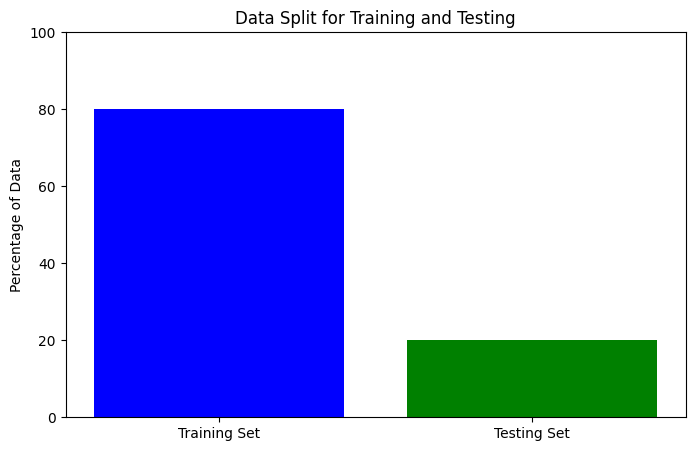

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_train and y_test are already defined from the split
train_size = len(y_train)
test_size = len(y_test)
total_size = train_size + test_size

# Calculate percentages
train_pct = (train_size / total_size) * 100
test_pct = (test_size / total_size) * 100

# Create bar plot
labels = ['Training Set', 'Testing Set']
sizes = [train_pct, test_pct]

plt.figure(figsize=(8, 5))
plt.bar(labels, sizes, color=['blue', 'green'])
plt.ylabel('Percentage of Data')
plt.title('Data Split for Training and Testing')
plt.ylim(0, 100)  # Extend y-axis to 100% for clearer visualization of proportions
plt.show()

In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
drive.mount('/content/drive')

# Load and preprocess datasets
df_labeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Labelled/New/Labelled_ARP Poison,flood attack Dataset.csv')
df_unlabeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Unlabelled/Unlabelled_ARP Poison,flood attack Dataset.csv')

Mounted at /content/drive


In [ ]:
import pandas as pd

def mac_to_integer(mac):
    """Convert a MAC address to an integer."""
    return -1 if mac == 'missing' else int(mac.replace(":", ""), 16)

def ip_to_integer(ip):
    """Convert an IPv4 address to an integer."""
    octets = map(int, ip.split('.'))
    return sum(octet << (8 * index) for index, octet in enumerate(reversed(list(octets))))

# Load labelled data
labelled_path = '/content/drive/Othercomputers/My laptop/Datasets/to be use/Labelled/New/Labelled_ARP Poison,flood attack Dataset.csv'
unlabelled_path = '/content/drive/Othercomputers/My laptop/Datasets/to be use/Unlabelled/Unlabelled_ARP Poison,flood attack Dataset.csv'
df_labelled.fillna('missing', inplace=True)

# Display original MAC and IP addresses
print("Original MAC and IP addresses (labelled data):")
print(df_labelled[['src_mac', 'dst_mac', 'src_ip', 'dst_ip']].head())

# Convert MAC and IP addresses
df_labelled['original_src_mac'] = df_labelled['src_mac']  # Preserve original for display
df_labelled['original_dst_mac'] = df_labelled['dst_mac']  # Preserve original for display
df_labelled['original_src_ip'] = df_labelled['src_ip']    # Preserve original for display
df_labelled['original_dst_ip'] = df_labelled['dst_ip']    # Preserve original for display

df_labelled['src_mac'] = df_labelled['src_mac'].apply(mac_to_integer)
df_labelled['dst_mac'] = df_labelled['dst_mac'].apply(mac_to_integer)
df_labelled['src_ip'] = df_labelled['src_ip'].apply(ip_to_integer)
df_labelled['dst_ip'] = df_labelled['dst_ip'].apply(ip_to_integer)

# Print the converted values
print("Converted MAC and IP to integers (labelled data):")
print(df_labelled[['original_src_mac', 'src_mac', 'original_dst_mac', 'dst_mac', 'original_src_ip', 'src_ip', 'original_dst_ip', 'dst_ip']].head())

NameError: name 'df_labelled' is not defined

In [ ]:
import pandas as pd

def mac_to_integer(mac):
    """Convert a MAC address to an integer."""
    return -1 if mac == 'missing' else int(mac.replace(":", ""), 16)

def ip_to_integer(ip):
    """Convert an IPv4 address to an integer."""
    octets = map(int, ip.split('.'))
    return sum(octet << (8 * index) for index, octet in enumerate(reversed(list(octets))))

# Load labelled data
df_labelled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Labelled/New/Labelled_ARP Poison,flood attack Dataset.csv')
df_labelled.fillna('missing', inplace=True)

# Display original MAC and IP addresses
print("Original MAC and IP addresses (labelled data):")
print(df_labelled[['src_mac_addr(eth)', 'src_mac_addr(arp)', 'dst_mac_addr(eth)', 'dst_mac_addr(arp)', 'src_ip(arp)', 'dst_ip(arp)']].head())

# Convert MAC and IP addresses
# Convert MAC and IP addresses
df_labelled['converted_src_mac_eth'] = df_labelled['src_mac_addr(eth)'].apply(mac_to_integer)
df_labelled['converted_dst_mac_eth'] = df_labelled['dst_mac_addr(eth)'].apply(mac_to_integer)
df_labelled['converted_src_mac_arp'] = df_labelled['src_mac_addr(arp)'].apply(mac_to_integer)
df_labelled['converted_dst_mac_arp'] = df_labelled['dst_mac_addr(arp)'].apply(mac_to_integer)
df_labelled['converted_src_ip_arp'] = df_labelled['src_ip(arp)'].apply(ip_to_integer)
df_labelled['converted_dst_ip_arp'] = df_labelled['dst_ip(arp)'].apply(ip_to_integer)

# Print the converted values
print("Converted MAC and IP to integers (labelled data):")
print(df_labelled[['src_mac_addr(eth)', 'converted_src_mac_eth', 'dst_mac_addr(eth)', 'converted_dst_mac_eth',
                    'src_mac_addr(arp)', 'converted_src_mac_arp', 'dst_mac_addr(arp)', 'converted_dst_mac_arp',
                    'src_ip(arp)', 'converted_src_ip_arp', 'dst_ip(arp)', 'converted_dst_ip_arp']].head())

Original MAC and IP addresses (labelled data):
   src_mac_addr(eth)  src_mac_addr(arp)  dst_mac_addr(eth)  dst_mac_addr(arp)  \
0  00:00:00:00:00:12  00:00:00:00:00:12  00:00:00:00:00:1b  00:00:00:00:00:00   
1  03:62:6b:2f:e4:7c  0c:42:1a:7c:04:34  ff:ff:ff:ff:ff:ff  00:00:00:00:00:00   
2  7f:b9:ed:76:58:53  f7:63:de:e3:13:12  ff:ff:ff:ff:ff:ff  00:00:00:00:00:00   
3  1c:02:26:e4:54:d4  87:10:4c:b6:d7:ce  ff:ff:ff:ff:ff:ff  00:00:00:00:00:00   
4  00:00:00:00:00:0e  00:00:00:00:00:0e  00:00:00:00:00:02  00:00:00:00:00:00   

       src_ip(arp) dst_ip(arp)  
0        10.0.0.18   10.0.0.27  
1   206.141.21.188    10.0.0.2  
2     215.57.98.53    10.0.0.2  
3  205.119.116.183    10.0.0.2  
4        10.0.0.14    10.0.0.2  
Converted MAC and IP to integers (labelled data):
   src_mac_addr(eth)  converted_src_mac_eth  dst_mac_addr(eth)  \
0  00:00:00:00:00:12                     18  00:00:00:00:00:1b   
1  03:62:6b:2f:e4:7c          3721239979132  ff:ff:ff:ff:ff:ff   
2  7f:b9:ed:76:58:53

In [ ]:
import pandas as pd

def mac_to_integer(mac):
    """Convert a MAC address to an integer."""
    return -1 if mac == 'missing' else int(mac.replace(":", ""), 16)

def ip_to_integer(ip):
    """Convert an IPv4 address to an integer."""
    octets = map(int, ip.split('.'))
    return sum(octet << (8 * index) for index, octet in enumerate(reversed(list(octets))))

# Load labelled data
df_labelled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Labelled/New/Labelled_ARP Poison,flood attack Dataset.csv')
df_unlabelled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Unlabelled/Unlabelled_ARP Poison,flood attack Dataset.csv')
df_labelled.fillna('missing', inplace=True)
df_unlabelled.fillna('missing', inplace=True)

# Display original MAC and IP addresses of Labelled Dataset
print("Original MAC and IP addresses (labelled data):")
print(df_labelled[['src_mac_addr(eth)', 'src_mac_addr(arp)', 'dst_mac_addr(eth)', 'dst_mac_addr(arp)', 'src_ip(arp)', 'dst_ip(arp)']].head())


# Convert MAC and IP addresses
df_labelled['converted_src_mac_eth'] = df_labelled['src_mac_addr(eth)'].apply(mac_to_integer)
df_labelled['converted_dst_mac_eth'] = df_labelled['dst_mac_addr(eth)'].apply(mac_to_integer)
df_labelled['converted_src_mac_arp'] = df_labelled['src_mac_addr(arp)'].apply(mac_to_integer)
df_labelled['converted_dst_mac_arp'] = df_labelled['dst_mac_addr(arp)'].apply(mac_to_integer)
df_labelled['converted_src_ip_arp'] = df_labelled['src_ip(arp)'].apply(ip_to_integer)
df_labelled['converted_dst_ip_arp'] = df_labelled['dst_ip(arp)'].apply(ip_to_integer)

# Print the converted values
print("Converted MAC and IP to integers (labelled data):")
print(df_labelled[['converted_src_mac_eth', 'converted_dst_mac_eth','converted_src_mac_arp', 'converted_dst_mac_arp','converted_src_ip_arp','converted_dst_ip_arp']].head())

# Display original MAC and IP addresses of Unlabelled Dataset
print("Original MAC and IP addresses (unlabelled data):")
print(df_unlabelled[['src_mac_addr(eth)', 'src_mac_addr(arp)', 'dst_mac_addr(eth)', 'dst_mac_addr(arp)', 'src_ip(arp)', 'dst_ip(arp)']].head())


# Convert MAC and IP addresses
df_unlabelled['converted_src_mac_eth'] = df_unlabelled['src_mac_addr(eth)'].apply(mac_to_integer)
df_unlabelled['converted_dst_mac_eth'] = df_unlabelled['dst_mac_addr(eth)'].apply(mac_to_integer)
df_unlabelled['converted_src_mac_arp'] = df_unlabelled['src_mac_addr(arp)'].apply(mac_to_integer)
df_unlabelled['converted_dst_mac_arp'] = df_unlabelled['dst_mac_addr(arp)'].apply(mac_to_integer)
df_unlabelled['converted_src_ip_arp'] = df_unlabelled['src_ip(arp)'].apply(ip_to_integer)
df_unlabelled['converted_dst_ip_arp'] = df_unlabelled['dst_ip(arp)'].apply(ip_to_integer)

# Print the converted values
print("Converted MAC and IP to integers (labelled data):")
print(df_unlabelled[['converted_src_mac_eth', 'converted_dst_mac_eth','converted_src_mac_arp', 'converted_dst_mac_arp','converted_src_ip_arp','converted_dst_ip_arp']].head())


Original MAC and IP addresses (labelled data):
   src_mac_addr(eth)  src_mac_addr(arp)  dst_mac_addr(eth)  dst_mac_addr(arp)      src_ip(arp) dst_ip(arp)
0  00:00:00:00:00:12  00:00:00:00:00:12  00:00:00:00:00:1b  00:00:00:00:00:00        10.0.0.18   10.0.0.27
1  03:62:6b:2f:e4:7c  0c:42:1a:7c:04:34  ff:ff:ff:ff:ff:ff  00:00:00:00:00:00   206.141.21.188    10.0.0.2
2  7f:b9:ed:76:58:53  f7:63:de:e3:13:12  ff:ff:ff:ff:ff:ff  00:00:00:00:00:00     215.57.98.53    10.0.0.2
3  1c:02:26:e4:54:d4  87:10:4c:b6:d7:ce  ff:ff:ff:ff:ff:ff  00:00:00:00:00:00  205.119.116.183    10.0.0.2
4  00:00:00:00:00:0e  00:00:00:00:00:0e  00:00:00:00:00:02  00:00:00:00:00:00        10.0.0.14    10.0.0.2
Converted MAC and IP to integers (labelled data):
   converted_src_mac_eth  converted_dst_mac_eth  converted_src_mac_arp  converted_dst_mac_arp  converted_src_ip_arp  converted_dst_ip_arp
0                     18                     27                     18                      0             167772178        

In [ ]:
import pandas as pd

# Load the datasets
df_labeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Labelled/New/Labelled_ARP Poison,flood attack Dataset.csv')
df_unlabeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Unlabelled/Unlabelled_ARP Poison,flood attack Dataset.csv')

# List to process both datasets
datasets = [df_labeled, df_unlabeled]
dataset_names = ["Labeled", "Unlabeled"]

for df, name in zip(datasets, dataset_names):
    # Print initial state of null values for each dataset
    print(f"Initial null values in {name} dataset:")
    print(df.isnull().sum())  # Summarizes the count of nulls in each column

    # Fill missing values with 'missing'
    df.fillna('missing', inplace=True)

    # Validate and print the results after filling nulls
    print(f"Null values in {name} dataset after filling missing values:")
    print(df.isnull().sum())  # Should show zero nulls across all columns

    # Optionally, print a small sample to visually confirm 'missing' entries
    print(f"Sample data from {name} dataset after null replacement:")
    print(df.sample(5))  # Random sample to show filled values


Initial null values in Labeled dataset:
switch_id              0
in_port                0
outport                0
src_mac_addr(eth)      0
src_mac_addr(arp)    128
dst_mac_addr(eth)      0
dst_mac_addr(arp)    128
src_ip(arp)            0
dst_ip(arp)            0
op_code(arp)           0
packet_in_count        0
Protocol               0
Pkt loss               0
rtt (avg)              0
total_time             0
Traffic_Label          0
dtype: int64
Null values in Labeled dataset after filling missing values:
switch_id            0
in_port              0
outport              0
src_mac_addr(eth)    0
src_mac_addr(arp)    0
dst_mac_addr(eth)    0
dst_mac_addr(arp)    0
src_ip(arp)          0
dst_ip(arp)          0
op_code(arp)         0
packet_in_count      0
Protocol             0
Pkt loss             0
rtt (avg)            0
total_time           0
Traffic_Label        0
dtype: int64
Sample data from Labeled dataset after null replacement:
       switch_id  in_port     outport  src_mac_a

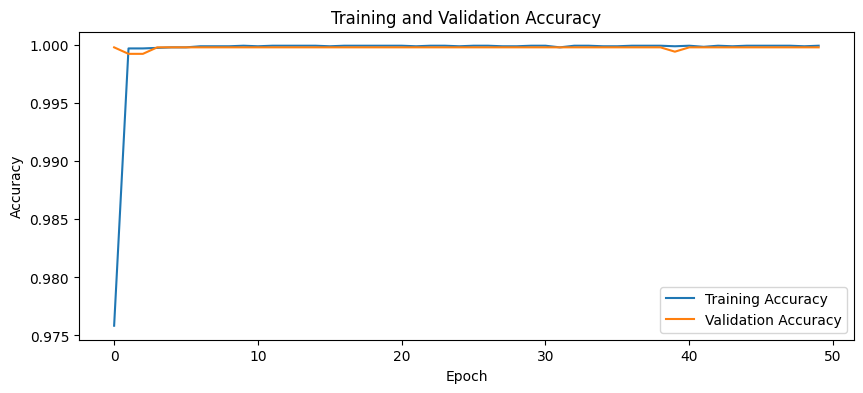

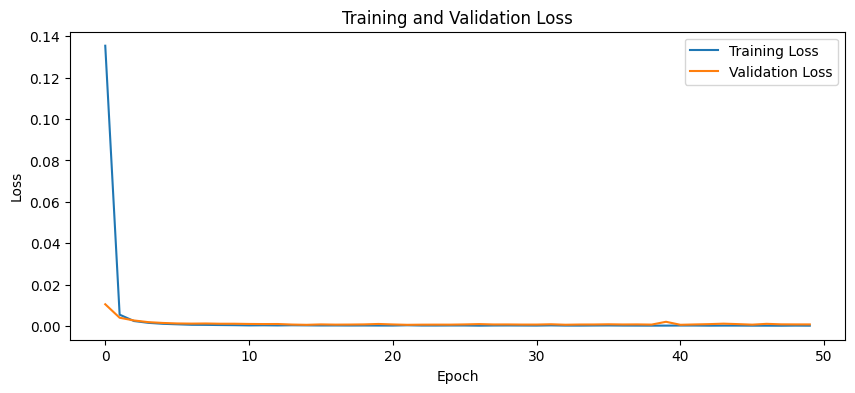

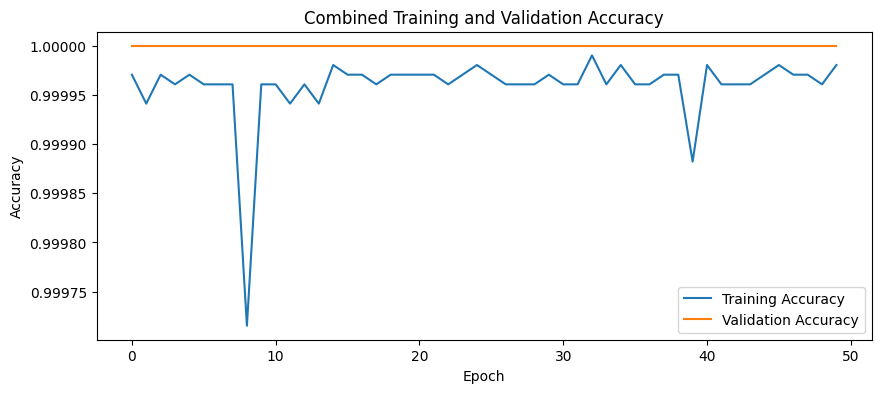

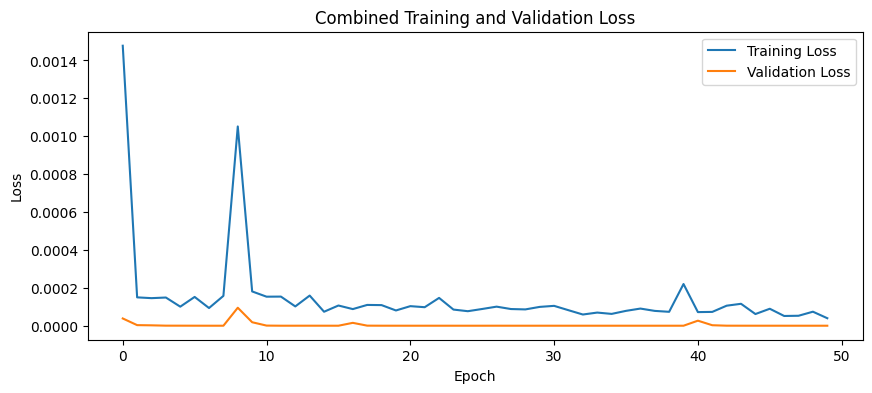

Unique classes in y_test: [0 1 2]
Unique classes in y_pred: [0 1 2]
Classification Report:
                 precision    recall  f1-score   support

Benign Traffic       1.00      1.00      1.00      1708
    ARP Poison       1.00      1.00      1.00       422
     ARP Flood       1.00      1.00      1.00      4570

      accuracy                           1.00      6700
     macro avg       1.00      1.00      1.00      6700
  weighted avg       1.00      1.00      1.00      6700



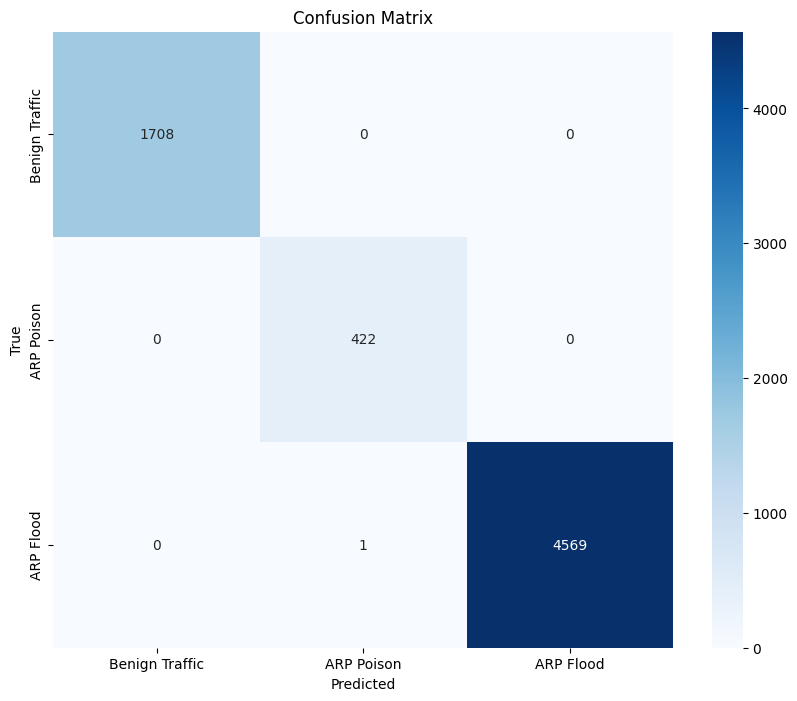

In [ ]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Training and Validation Accuracy for combined dataset
plt.figure(figsize=(10, 4))
plt.plot(combined_history.history['accuracy'], label='Training Accuracy')
plt.plot(combined_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Combined Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Training and Validation Loss for combined dataset
plt.figure(figsize=(10, 4))
plt.plot(combined_history.history['loss'], label='Training Loss')
plt.plot(combined_history.history['val_loss'], label='Validation Loss')
plt.title('Combined Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Check unique classes in the test labels and predictions
print("Unique classes in y_test:", np.unique(y_test))
print("Unique classes in y_pred:", np.unique(y_pred))

# Ensure that the classification report includes all four classes
class_names = ['Benign Traffic', 'ARP Poison', 'ARP Flood']
# Generate the classification report
report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)
print("Classification Report:\n", report)

# Plot the confusion matrix with all expected classes
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Input layer
input_layer = Input(shape=(1, X_train.shape[1]))

# LSTM layer
# Make sure to set return_sequences=True if you want the outputs at all time steps,
# or return_sequences=False if you just want the last output
lstm_layer, state_h, state_c = LSTM(50, return_state=True, return_sequences=False)(input_layer)

# Output layer for classification
output_layer = Dense(num_classes, activation='softmax')(state_h)

# Create model instance specifying inputs and outputs
model = Model(inputs=input_layer, outputs=[output_layer, state_h])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model to understand its structure
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 15)]           0         
                                                                 
 lstm_1 (LSTM)               [(None, 50),              13200     
                              (None, 50),                        
                              (None, 50)]                        
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 13353 (52.16 KB)
Trainable params: 13353 (52.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(X_train_lstm, [y_train, y_train], epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
670/670 [==============================] - 8s 5ms/step - loss: 1.6762 - dense_1_loss: 0.3427 - lstm_1_loss: 1.3334 - dense_1_accuracy: 0.9271 - lstm_1_accuracy: 0.8243 - val_loss: 0.3263 - val_dense_1_loss: 0.1142 - val_lstm_1_loss: 0.2122 - val_dense_1_accuracy: 0.9375 - val_lstm_1_accuracy: 0.9343
Epoch 2/50
670/670 [==============================] - 3s 4ms/step - loss: 0.1940 - dense_1_loss: 0.0512 - lstm_1_loss: 0.1428 - dense_1_accuracy: 0.9883 - lstm_1_accuracy: 0.9599 - val_loss: 0.1105 - val_dense_1_loss: 0.0255 - val_lstm_1_loss: 0.0850 - val_dense_1_accuracy: 0.9959 - val_lstm_1_accuracy: 0.9866
Epoch 3/50
670/670 [==============================] - 3s 4ms/step - loss: 0.0799 - dense_1_loss: 0.0155 - lstm_1_loss: 0.0644 - dense_1_accuracy: 0.9994 - lstm_1_accuracy: 0.9886 - val_loss: 0.0592 - val_dense_1_loss: 0.0114 - val_lstm_1_loss: 0.0479 - val_dense_1_accuracy: 0.9993 - val_lstm_1_accuracy: 0.9879
Epoch 4/50
670/670 [==============================] - 3s 5ms/ste

In [ ]:
# Feature extraction
features_labeled, _ = model.predict(X_train_lstm)
features_unlabeled, _ = model.predict(X_unlabeled)

# Print some of the extracted features to validate
print("Sample features from labeled data:", features_labeled[:5])
print("Sample features from unlabeled data:", features_unlabeled[:5])


3141/3141 [==============================] - 8s 3ms/step
Sample features from labeled data: [[9.9999982e-01 9.2210772e-09 8.7593342e-08]
 [3.8553430e-16 1.2060523e-20 9.9999994e-01]
 [9.2889709e-16 4.6101065e-16 9.9999994e-01]
 [5.9419857e-15 4.8131783e-15 9.9999994e-01]
 [1.2630283e-16 1.2937725e-19 9.9999994e-01]]
Sample features from unlabeled data: [[2.7710232e-11 9.9999994e-01 3.3530935e-25]
 [2.2914251e-15 6.0867336e-20 9.9999994e-01]
 [3.3857654e-18 8.7029084e-24 9.9999994e-01]
 [3.3857654e-18 8.7029084e-24 9.9999994e-01]
 [2.4067071e-19 1.1857823e-22 9.9999994e-01]]


In [ ]:
# Feature extraction
features_labeled, _ = model.predict(X_train_lstm)
features_unlabeled, _ = model.predict(X_unlabeled)

# Print some of the extracted features to validate
print("Sample features from labeled data:", features_labeled[:5])
print("Sample features from unlabeled data:", features_unlabeled[:5])


3141/3141 [==============================] - 7s 2ms/step
Sample features from labeled data: [[0.405901   0.30357075 0.29052818]
 [0.30790424 0.35050082 0.34159485]
 [0.3321477  0.32646117 0.34139115]
 [0.34785295 0.295381   0.35676602]
 [0.33088973 0.33547986 0.3336305 ]]
Sample features from unlabeled data: [[0.34874052 0.43918568 0.21207383]
 [0.19332151 0.22329187 0.58338666]
 [0.2623543  0.25772268 0.479923  ]
 [0.26377165 0.2605649  0.47566348]
 [0.1802708  0.2604034  0.5593258 ]]


In [ ]:
# Predict pseudo-labels for unlabeled data
pseudo_labels = lstm_model.predict(X_unlabeled).argmax(axis=-1)
print(f"Pseudo labels: {pseudo_labels}")

3141/3141 [==============================] - 13s 4ms/step
Pseudo labels: [2 2 2 ... 2 2 2]


210/210 [==============================] - 1s 6ms/step - loss: 2.8803e-04 - accuracy: 1.0000
Model evaluation (loss, accuracy): [0.0002880290267057717, 1.0]
Classification Report:
                 precision    recall  f1-score   support

Benign Traffic       1.00      1.00      1.00      1708
    ARP Poison       1.00      1.00      1.00       422
     ARP Flood       1.00      1.00      1.00      4570

      accuracy                           1.00      6700
     macro avg       1.00      1.00      1.00      6700
  weighted avg       1.00      1.00      1.00      6700



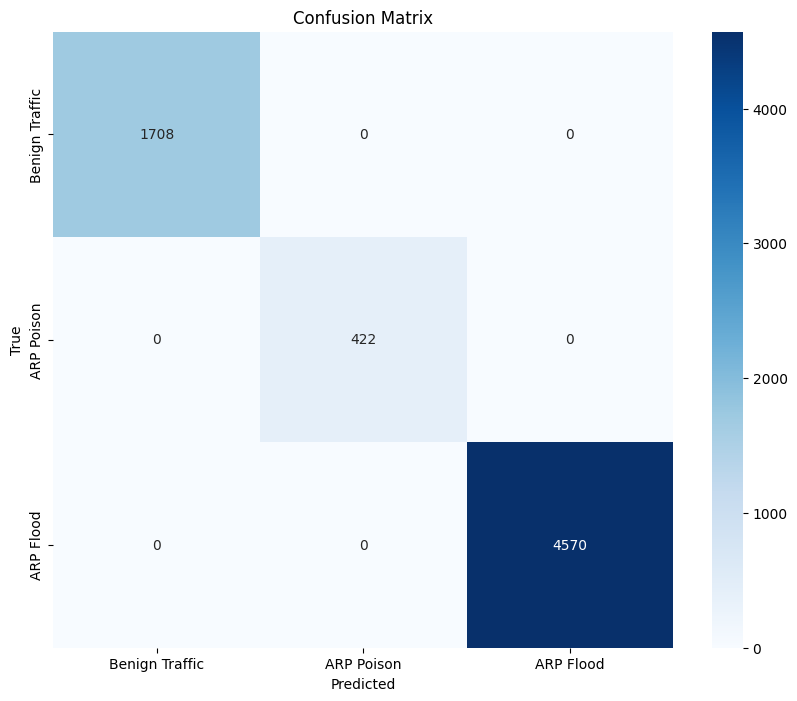

In [ ]:
# Evaluation on test data
evaluation = lstm_model.evaluate(X_test_lstm, y_test, verbose=1)
print(f"Model evaluation (loss, accuracy): {evaluation}")

# Classification report and confusion matrix
report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)
print("Classification Report:\n", report)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
evaluation = lstm_model.evaluate(X_test_lstm, y_test, verbose=1)
print(f"Initial model evaluation (loss, accuracy): {evaluation}")

210/210 [==============================] - 1s 3ms/step - loss: 2.8803e-04 - accuracy: 1.0000
Initial model evaluation (loss, accuracy): [0.0002880290267057717, 1.0]


In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

# Assuming each sample has a shape of (1, number_of_features)
input_shape = (1, X_train.shape[1])

# Define the model
inputs = Input(shape=input_shape)
lstm_out, state_h, state_c = LSTM(50, return_sequences=False, return_state=True)(inputs)
outputs = Dense(num_classes, activation='softmax')(lstm_out)

# Now create the model that returns the last output and the state (feature)
model = Model(inputs=inputs, outputs=[outputs, lstm_out])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Predict using the new model to get both predictions and features
predictions, test_features = model.predict(X_test_lstm)
print("Extracted features from the test data:", test_features[:5])

210/210 [==============================] - 1s 4ms/step
Extracted features from the test data: [[ 0.13438387 -0.07871866 -0.06858387  0.06290315  0.01991482 -0.15705135
   0.1041763   0.15755546  0.01819201  0.07322894  0.10239288 -0.06043971
   0.10954829  0.00266063 -0.0464373  -0.08795169  0.07003396 -0.05303823
   0.03179697 -0.14324616  0.11240982  0.01786181 -0.16593325 -0.02525455
   0.12297744 -0.02011111  0.07335454 -0.09181481 -0.07344691  0.01105113
   0.02514197  0.0545365   0.01607487 -0.07067483 -0.07155264  0.00866159
   0.07662961 -0.07358284  0.11775352 -0.0324182   0.01918152  0.01039888
  -0.04886881 -0.00332226 -0.00815868  0.01476699  0.04395039  0.0115679
  -0.00716979  0.03776683]
 [ 0.06310087 -0.00583741 -0.02992694  0.05483367  0.0144731  -0.07313015
   0.04614169  0.12028934 -0.01983789  0.03340289  0.06053675 -0.03755297
   0.02529493  0.0004353  -0.0318535  -0.03399837  0.03039363 -0.02618955
   0.04955904 -0.06524595  0.08419853 -0.03918828 -0.04895552 -0.1

In [ ]:
# Evaluation might need to adjust to use only predictions
evaluation = model.evaluate(X_test_lstm, y_test, verbose=1)
print(f"Model evaluation (loss, accuracy): {evaluation}")

# If needed, adjust confusion matrix and classification reports to use predictions
y_pred = np.argmax(predictions, axis=-1)

210/210 [==============================] - 4s 7ms/step - loss: 14.9880 - dense_2_loss: 1.1536 - lstm_2_loss: 13.8344 - dense_2_accuracy: 0.0888 - lstm_2_accuracy: 0.0000e+00
Model evaluation (loss, accuracy): [14.987959861755371, 1.153564691543579, 13.834386825561523, 0.08880597352981567, 0.0]


In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

# Assuming your input data shape is correctly defined as follows:
input_shape = (1, X_train.shape[1])  # Number of features in X_train

# Define model inputs and LSTM configuration
inputs = Input(shape=input_shape)
lstm_out = LSTM(50, return_sequences=False)(inputs)  # Set return_sequences=False if you want the output at the last timestep
outputs = Dense(num_classes, activation='softmax')(lstm_out)

# Create the model with inputs and outputs
model = Model(inputs=inputs, outputs=[outputs, lstm_out])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Predict using the modified model
predictions, features = model.predict(X_test.reshape((X_test.shape[0], 1, X_test.shape[1])))

# Now, predictions contain the class probabilities, and features contain the LSTM outputs
print("Extracted features from the test data:", features[:5])


210/210 [==============================] - 2s 3ms/step
Extracted features from the test data: [[-0.0192366  -0.01494747  0.03203144 -0.11859334  0.01138924  0.02771591
  -0.00548034 -0.07241254 -0.05359765 -0.07923514 -0.16417867 -0.09294475
  -0.09431162 -0.00288813 -0.05757229 -0.02658105  0.0244387   0.04426158
   0.06842476  0.03887045 -0.04387516 -0.02503495  0.0588748  -0.07808852
  -0.03841053  0.01525471  0.01702332 -0.03265975 -0.00520448  0.01734099
   0.01519746 -0.0544026   0.03854119  0.05292616  0.03268302  0.05239573
  -0.11361172 -0.08935535  0.02103714 -0.01342517  0.06346454  0.07722326
   0.08482055  0.05192402 -0.02805069  0.08009627 -0.02304781 -0.04180777
   0.06314328  0.0112567 ]
 [ 0.00041024 -0.02256358 -0.0315932  -0.01815227  0.09188019  0.02503651
  -0.00687624  0.03968834 -0.01760995 -0.03064442 -0.07879135 -0.03572002
  -0.05221843 -0.00819471 -0.06211784 -0.01828313 -0.02245346  0.02044153
   0.04219077  0.04989025  0.0165916  -0.02440945  0.03211964 -0.

In [ ]:
# Example: Print first 5 features to check
print("Extracted features from the test data:", features[:5])

Extracted features from the test data: [[-0.0192366  -0.01494747  0.03203144 -0.11859334  0.01138924  0.02771591
  -0.00548034 -0.07241254 -0.05359765 -0.07923514 -0.16417867 -0.09294475
  -0.09431162 -0.00288813 -0.05757229 -0.02658105  0.0244387   0.04426158
   0.06842476  0.03887045 -0.04387516 -0.02503495  0.0588748  -0.07808852
  -0.03841053  0.01525471  0.01702332 -0.03265975 -0.00520448  0.01734099
   0.01519746 -0.0544026   0.03854119  0.05292616  0.03268302  0.05239573
  -0.11361172 -0.08935535  0.02103714 -0.01342517  0.06346454  0.07722326
   0.08482055  0.05192402 -0.02805069  0.08009627 -0.02304781 -0.04180777
   0.06314328  0.0112567 ]
 [ 0.00041024 -0.02256358 -0.0315932  -0.01815227  0.09188019  0.02503651
  -0.00687624  0.03968834 -0.01760995 -0.03064442 -0.07879135 -0.03572002
  -0.05221843 -0.00819471 -0.06211784 -0.01828313 -0.02245346  0.02044153
   0.04219077  0.04989025  0.0165916  -0.02440945  0.03211964 -0.02048237
  -0.00837619 -0.00148933 -0.00994159 -0.01822

In [ ]:
# Check the contents of the list
if isinstance(predictions, list):
    print("List contents:", predictions)
    # If the list contains one array, use it
    if len(predictions) == 1 and isinstance(predictions[0], np.ndarray):
        predictions = predictions[0]
    elif all(isinstance(elem, np.ndarray) for elem in predictions):
        # If the list contains multiple arrays and you need to concatenate them
        predictions = np.concatenate(predictions, axis=-1)

# Now apply argmax to get pseudo-labels
pseudo_labels = predictions.argmax(axis=-1)
print(f"Pseudo labels generated for unlabeled data: {pseudo_labels[:5]}")


List contents: [array([[0.42268026, 0.22418812, 0.35313165],
       [0.27065533, 0.28957745, 0.43976715],
       [0.21882398, 0.5866515 , 0.19452438],
       ...,
       [0.14119856, 0.22146758, 0.6373338 ],
       [0.42268032, 0.22418812, 0.35313162],
       [0.19986032, 0.2929829 , 0.5071568 ]], dtype=float32), array([[ 0.       ,  0.       ,  0.       , ...,  0.       , -0.       ,
         0.       ],
       [-0.       ,  0.7615942,  0.       , ...,  0.       ,  0.7615942,
        -0.7615942],
       [-0.7615942,  0.       , -0.7615942, ...,  0.       ,  0.7615942,
        -0.7615942],
       ...,
       [-0.       ,  0.7615942,  0.       , ...,  0.       ,  0.7615942,
         0.7615942],
       [ 0.       ,  0.       ,  0.       , ...,  0.       , -0.       ,
         0.       ],
       [-0.7615942,  0.7615942, -0.7615942, ...,  0.       ,  0.7615942,
        -0.7615942]], dtype=float32)]
Pseudo labels generated for unlabeled data: [ 8  4 16 16 16]


In [ ]:
# Assuming predictions[0] is the array with class probabilities
predictions = predictions[0]

# Apply argmax to get pseudo-labels
pseudo_labels = predictions.argmax(axis=-1)
print(f"Pseudo labels generated for unlabeled data: {pseudo_labels[:5]}")

# Optionally, check the shape and content of the second array if it is of interest
if len(predictions) > 1:
    print("Second output array shape:", predictions[1].shape)
    print("Second output array sample data:", predictions[1][:5])

IndexError: invalid index to scalar variable.

In [ ]:
# Verify and inspect the predictions list to select the correct array
if isinstance(predictions, list) and len(predictions) > 0:
    # Assuming the first array in the list is what we need
    class_probabilities = predictions[0]
    print("Shape of class probabilities:", class_probabilities.shape)
    # Apply argmax to get pseudo-labels
    pseudo_labels = class_probabilities.argmax(axis=-1)
    print(f"Pseudo labels generated for unlabeled data: {pseudo_labels[:5]}")
else:
    print("Predictions may not be in the expected format:", predictions)


Predictions may not be in the expected format: [ 0.42268026  0.22418812  0.35313165  0.          0.          0.
  0.          0.          0.7615942  -0.7615942   0.          0.
 -0.7615942   0.7615942   0.          0.          0.          0.
  0.          0.7615942   0.          0.          0.          0.
  0.         -0.7615942  -0.         -0.7615942   0.          0.
  0.         -0.         -0.7615942   0.         -0.7615942  -0.
  0.7615942  -0.7615942   0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.7615942
 -0.          0.          0.         -0.          0.        ]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50
670/670 [==============================] - 5s 5ms/step - loss: 0.1334 - accuracy: 0.9782 - val_loss: 0.0107 - val_accuracy: 0.9998
Epoch 2/50
670/670 [==============================] - 3s 5ms/step - loss: 0.0054 - accuracy: 0.9998 - val_loss: 0.0040 - val_accuracy: 0.9993
Epoch 3/50
670/670 [==============================] - 4s 5ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 0.0026 - val_accuracy: 0.9998
Epoch 4/50
670/670 [==============================] - 2s 4ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.0020 - val_accuracy: 0.9998
Epoch 5/50
670/670 [==============================] - 2s 3ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0016 - val_accuracy: 0.9996
Epoch 6/50
670/670 [==============================] - 2s 4ms/step - loss: 8.5543e-04 - accuracy: 0.9999 - val_loss: 0.0015 - val_accuracy: 0.9998
Epoch 7/50
670/

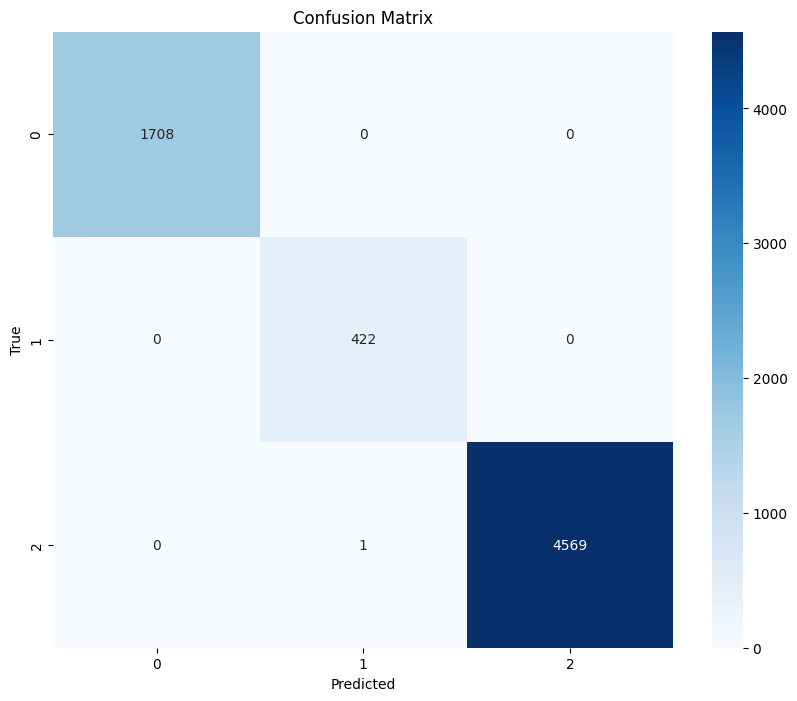

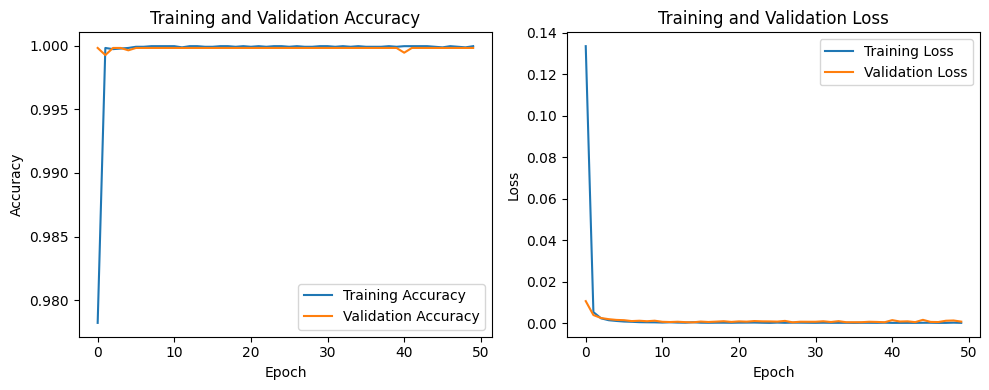

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from google.colab import drive

# Function to convert MAC and IP addresses to integers
def mac_to_integer(mac):
    return -1 if mac == 'missing' else int(mac.replace(":", ""), 16)

def ip_to_integer(ip):
    octets = map(int, ip.split('.'))
    return sum(octet << (8 * index) for index, octet in enumerate(reversed(list(octets))))

# Mount Google Drive
drive.mount('/content/drive')

# Load and preprocess datasets
df_labeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Labelled/New/Labelled_ARP Poison,flood attack Dataset.csv')
df_unlabeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Unlabelled/Unlabelled_ARP Poison,flood attack Dataset.csv')

for df in [df_labeled, df_unlabeled]:
    df.fillna('missing', inplace=True)
    for col in ['src_mac_addr(eth)', 'src_mac_addr(arp)', 'dst_mac_addr(eth)', 'dst_mac_addr(arp)', 'src_ip(arp)', 'dst_ip(arp)']:
        df[col] = df[col].apply(mac_to_integer if 'mac_addr' in col else ip_to_integer)

# Scale features
scaler = StandardScaler()
features_labeled = df_labeled.drop('Traffic_Label', axis=1)
features_unlabeled = df_unlabeled[features_labeled.columns]  # Assume same structure

X_labeled = scaler.fit_transform(features_labeled)
X_unlabeled = scaler.transform(features_unlabeled)

y_labeled = df_labeled['Traffic_Label'].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_unlabeled = X_unlabeled.reshape((X_unlabeled.shape[0], 1, X_unlabeled.shape[1]))

# LSTM Model
num_classes = len(np.unique(y_labeled))
model = Sequential([
    LSTM(50, input_shape=(1, X_train.shape[2])),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Predict and generate pseudo-labels
pseudo_labels = model.predict(X_unlabeled).argmax(axis=-1)

# Combine datasets for re-training
X_combined = np.concatenate((X_train, X_unlabeled))
y_combined = np.concatenate((y_train, pseudo_labels))

# Fit the model on the combined dataset
combined_history = model.fit(X_combined, y_combined, epochs=50, batch_size=32, validation_split=0.2)

# Evaluation
evaluation = model.evaluate(X_test, y_test, verbose=1)
print(f"Model evaluation (loss, accuracy): {evaluation}")

# Generate classification report
y_pred = model.predict(X_test).argmax(axis=-1)
report = classification_report(y_test, y_pred, zero_division=0)
print("Classification Report:\n", report)

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plotting accuracy and loss graphs
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Assuming df_labeled is already loaded and processed as per your earlier code
features = df_labeled.drop('Traffic_Label', axis=1).values
labels = df_labeled['Traffic_Label'].values

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(features)

# Reshape X for LSTM as you do for your training data
X = X.reshape((X.shape[0], 1, X.shape[1]))

# 'y' is straightforward since it's just your labels
y = labels

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Prepare the model creation function
def create_model(input_shape, num_classes):
    model = Sequential([
        LSTM(50, input_shape=input_shape),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Number of splits for cross-validation
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Collect scores
scores = []

# Ensure data is reshaped for LSTM if not already
# This is done above now, so we assume X and y are ready to use
num_classes = len(np.unique(y))

# Perform cross-validation
for train_idx, test_idx in kfold.split(X, y):
    model = create_model((1, X.shape[2]), num_classes)
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Fit model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Evaluate the model on the test set
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    scores.append(accuracy)

# Print the performance
print('Accuracy scores for each fold:', scores)
print('Mean accuracy:', np.mean(scores))
print('Standard deviation:', np.std(scores))

Accuracy scores for each fold: [1.0, 1.0, 0.9998507499694824, 0.9998507499694824, 0.9998507499694824]
Mean accuracy: 0.9999104499816894
Standard deviation: 7.311728377257678e-05
